In [1]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F

import transformers
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

from time import time

In [2]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto"
    labels_list = f"{DRIVE_FOLDER}/xeno_labels.csv"
    model_name = "ast_baseline"
    backbone_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
    n_classes = 397 # number of classes in the dataset
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    batch_size = 4 
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 5
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 200
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_everything(config.random_seed)

In [4]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

df_audio_meta.head(5)

Number of classes with less than 2 samples: 72
Number of classes in dataset: 728
Number of samples: 11171


,file_name,category_number,common_name,audio_length,type,remarks,quality,mp3_link,scientific_name,region,file_exists,species_id
0,data/XC228210-Blue-crowned_Manakin_B_9369_0.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
1,data/XC228210-Blue-crowned_Manakin_B_9369_1.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
2,data/XC200163-PIPCOR03_0.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
3,data/XC200163-PIPCOR03_1.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
4,data/XC200163-PIPCOR03_2.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329


In [5]:
class BirdSongDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.feature_extractor = ASTFeatureExtractor()
        self.config = config
    
    def __len__(self):
        return len(self.df_audio_meta)

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
        audio_arr, sr = self.get_audio(audio_path)
        spec = self.feature_extractor(audio_arr, sampling_rate=sr, padding="max_length", return_tensors="pt")
        return spec['input_values'].squeeze(0), row['species_id']

    def get_audio(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.config.audio_sr)
        return audio, sr

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

In [6]:
class BirdAST(nn.Module):
    
    def __init__(self, backbone_name, n_classes, n_mlp_layers=1, activation='silu'):
        super(BirdAST, self).__init__()
        
        # pre-trained backbone
        backbone_config = ASTConfig.from_pretrained(backbone_name)
        self.ast = ASTModel.from_pretrained(backbone_name, config=backbone_config)
        self.hidden_size = backbone_config.hidden_size
        
        # set activation functions
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        else:
            raise ValueError("Unsupported activation function. Choose 'relu' or 'silu'.")
        
        # define MLP layers with activation
        layers = []
        for _ in range(n_mlp_layers):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(self.activation)
        layers.append(nn.Linear(self.hidden_size, n_classes))
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, spectrogram):
        # spectrogram: (batch_size, n_mels, n_frames)
        # output: (batch_size, n_classes)
        
        ast_output = self.ast(spectrogram, output_hidden_states=True) # !!! output_hidden_states=True
        logits = self.mlp(ast_output.last_hidden_state[:, 0, :]) # Use the CLS token 
        
        return {'logits': logits, 'hidden_states': ast_output.hidden_states}

In [7]:
bs_dataset = BirdSongDataset(df_audio_meta, config)
bs_dataloader = DataLoader(bs_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [8]:
model = BirdAST(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')
model_weights_pth = [
    f"{config.log_dir}/{config.model_name}_fold_{fold_id}" + ".pth" for fold_id in range(config.n_splits)
    ]

for _weights in model_weights_pth:
    assert os.path.exists(_weights), f"Model weights file {_weights} does not exist."

In [9]:
def get_features(model, dataloader, checkpoint_pth=None):
    # use only the last hidden state cls token as features for cluster
    if checkpoint_pth is not None:
        model.load_state_dict(torch.load(checkpoint_pth, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    hidden_states = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            spectrogram = batch['input_ids'].to(DEVICE)
            output = model(spectrogram)
            hidden_states.append(output['hidden_states'][-1][:, 0, :].cpu())
    return torch.cat(hidden_states, dim=0)

In [10]:
sample_feat_collects = [
    get_features(model, bs_dataloader, checkpoint_pth=model_weights_pth[i]) 
    for i in range(config.n_splits)
    ]

sample_features = torch.stack(sample_feat_collects, dim=0).mean(dim=0)

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

In [14]:
sample_features.shape

torch.Size([11171, 768])

In [11]:
# apply k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


  0%|          | 0/95 [00:00<?, ?it/s]

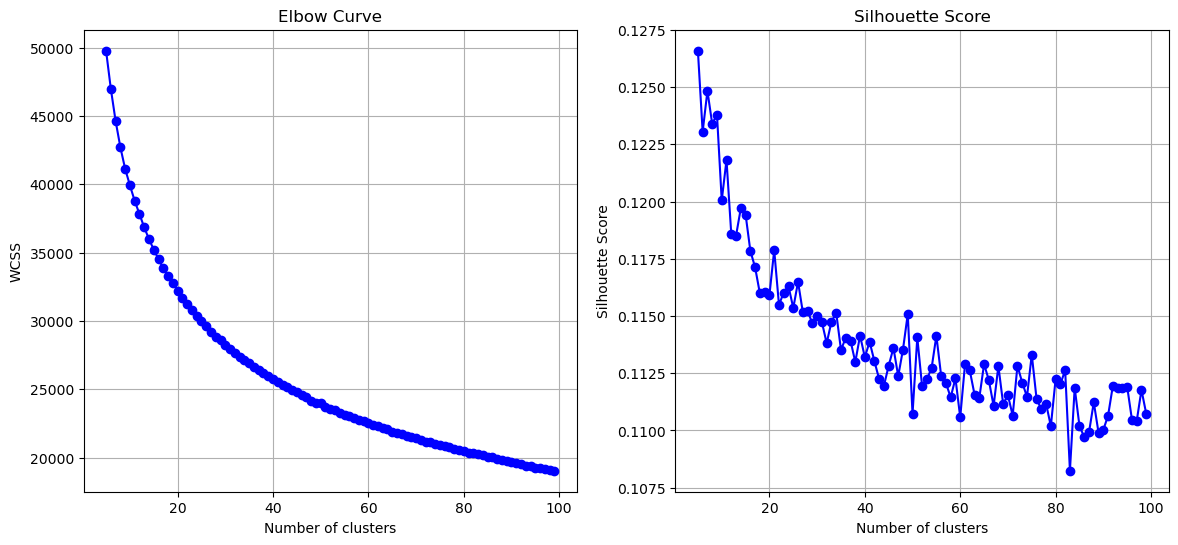

In [17]:
# apply PCA to features

# create a PCA object
pca = PCA(n_components=6)

# fit and transform the data to the model
reduced_features = pca.fit_transform(sample_features)

# calculate wcss for different number of clusters
wcss_reduced = []
sil_scores_reduced = []

n_clusters = np.arange(5, 100)
for n in tqdm(n_clusters):
    kmeans = KMeans(n_clusters=n, random_state=config.random_seed)
    cluster_labels = kmeans.fit_predict(reduced_features)
    sil_scores_reduced.append(silhouette_score(reduced_features, cluster_labels))
    wcss_reduced.append(kmeans.inertia_)
    
# plot the elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.plot(n_clusters, wcss_reduced, marker='o', color='b')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
ax.set_title('Elbow Curve')
ax.grid(True)

ax = axes[1]
ax.plot(n_clusters, sil_scores_reduced, marker='o', color='b')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score')
ax.grid(True)

plt.show()
    

In [12]:
# calculate wcss for different number of clusters
wcss = []
sil_scores = []

n_clusters = np.arange(5, 100)
for n in tqdm(n_clusters):
    kmeans = KMeans(n_clusters=n, random_state=config.random_seed)
    cluster_labels = kmeans.fit_predict(sample_features)
    sil_scores.append(silhouette_score(sample_features, cluster_labels))
    wcss.append(kmeans.inertia_)


  0%|          | 0/95 [00:00<?, ?it/s]

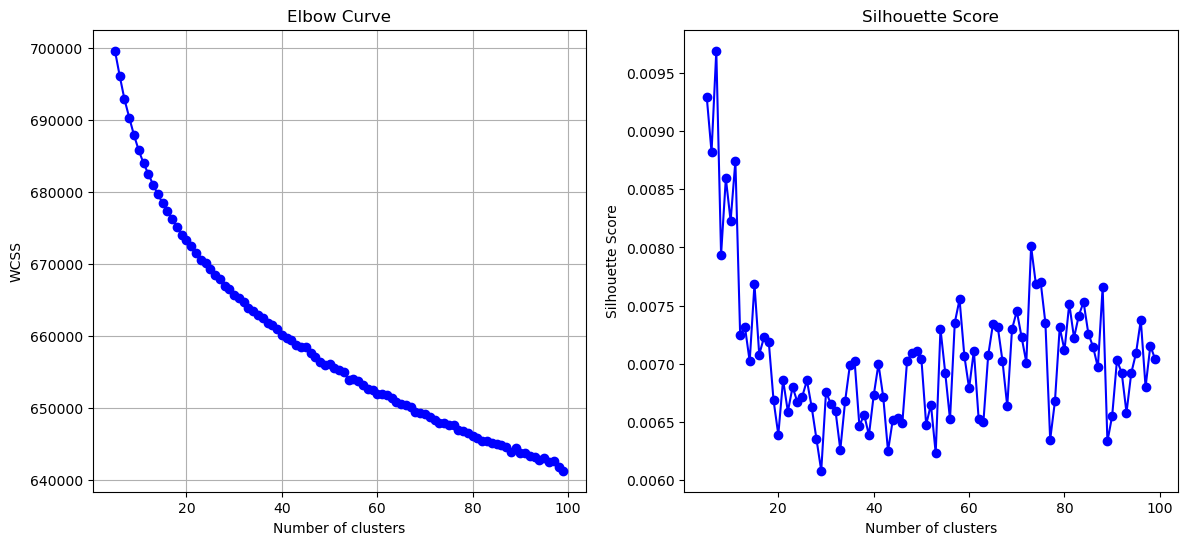

In [13]:
# plot the elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.plot(n_clusters, wcss, marker='o', color='b')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
ax.set_title('Elbow Curve')
ax.grid(True)

ax = axes[1]
ax.plot(n_clusters, sil_scores, marker='o', color='b')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score')
plt.show()
